# Import Packages

In [31]:
import pandas as pd
from sodapy import Socrata
import os
import re
import requests
import json
import folium
from folium import plugins
from folium.plugins import HeatMap
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import numpy as np
from scipy import stats
import statsmodels.api as sm

pd.set_option("display.max_columns", None)

# Functions

In [32]:
def human_address(dataframe):
    """extract and convert the address in permit location column to 123 jake way, silver sprind, md 20904 format
    and create list to make new a column"""
    output = [] 
    for i,row in dataframe.iterrows():
        human_address = row.location.get('human_address')
        pattern = re.compile('[",{,},a-z]')
        clean_address = re.sub(pattern, '', human_address)
        address_lst = clean_address.split(':')
        address = f"{address_lst[1].strip()}, {address_lst[2].strip()}, {address_lst[3].strip()} {address_lst[4].strip()}"
        output.append(address.lower())
    return output


def lat_long_extraction(dataframe):
    """Extract latitude and longitude from location column and create two list to make new columns"""
    latitude_lst = []
    longitude_lst = []
    for i , row in dataframe.iterrows():
        latitude = row.location.get('latitude')
        longitude = row.location.get('longitude')
        latitude_lst.append(latitude)
        longitude_lst.append(longitude)
    return latitude_lst,longitude_lst

def google_lat_long(dataframe):
    """google API call to find latitude and longitude from the address and create two list to make new columns """
    latitude_lst = []
    longitude_lst = []
    for address in human_address(dataframe):
       
        #example from google to use api to get latitude and longitude
        api_key = "API KEY"
        api_response = requests.get('https://maps.googleapis.com/maps/api/geocode/json?address={0}&key={1}'.format(
            address, api_key))
        api_response_dict = api_response.json()

        if api_response_dict['status'] == 'OK':
            latitude = api_response_dict['results'][0]['geometry']['location']['lat']
            longitude = api_response_dict['results'][0]['geometry']['location']['lng']
            latitude_lst.append(latitude)
            longitude_lst.append(longitude)
        else:
            latitude_lst.append(0)
            longitude_lst.append(0)
    return latitude_lst,longitude_lst


def zillow_api(home_type):
    """Acquire Zillow data from API for properties on the market by home type"""
    url = "https://zillow-com1.p.rapidapi.com/propertyExtendedSearch"

    querystring = {"location":"montgomery county, md","page":"1","status_type":"ForSale","home_type":home_type,
                   "sort":"Newest","maxPrice":"587000"}

    headers = {
        "X-RapidAPI-Host": "zillow-com1.p.rapidapi.com",
        "X-RapidAPI-Key": "API KEY"}

    #API Call 
    response = requests.request("GET", url, headers=headers, params=querystring)

    #convert response to dictionary
    result = json.loads(response.text)

    #convert dictionary to dataframe
    zillow_df = pd.DataFrame.from_dict(result.get('props')) 

    if result.get('totalPages', 0) > 1:
        count = 2
        for x in range(result.get('totalPages')-1):
            if x == 0:
                querystring['page'] = x + count 
                response = requests.request("GET", url, headers=headers, params=querystring)
                result = json.loads(response.text)
                zillow_temp_df = pd.DataFrame.from_dict(result.get('props')) 
                full_zillow_df = pd.concat([zillow_df, zillow_temp_df])
            else:
                querystring['page'] = x + count 
                response = requests.request("GET", url, headers=headers, params=querystring)
                result = json.loads(response.text)
                zillow_temp_df = pd.DataFrame.from_dict(result.get('props')) 
                full_zillow_df = pd.concat([full_zillow_df, zillow_temp_df]) 
        return full_zillow_df
    else:
        return zillow_df

def finaled_permit_price_n_year(data):
    """Acquire the year and home price of the house sold after the permit has been finalized"""
    year = []
    cost = []
    for i,row in data.iterrows():
        if row.sales_date_3 > row.finaleddate:
            year.append(row.year_3)
            cost.append(row.sales_price_3)
        elif row.sales_date_2 > row.finaleddate:
            year.append(row.year_2)
            cost.append(row.sales_price_2)
        elif row.sales_date > row.finaleddate:
            year.append(row.year)
            cost.append(row.sales_price)
        else:
            pass
    return year,cost
 
def unfinished_permit_price_n_year(data):
    """Acquire the year and home price of the house sold after the permit has been issued"""
    year = []
    cost = []
    for i,row in data.iterrows():
        if row.sales_date_3 > row.issueddate:
            year.append(row.year_3)
            cost.append(row.sales_price_3)
        elif row.sales_date_2 > row.issueddate:
            year.append(row.year_2)
            cost.append(row.sales_price_2)
        elif row.sales_date > row.issueddate:
            year.append(row.year)
            cost.append(row.sales_price)
        else:
            pass
    return year,cost
 

# Data

## Upload Residential Permits from Scorate API

In [33]:
#authenticate client
client = Socrata('data.montgomerycountymd.gov',"MyAppToken","userame='user@example.com'","password='AFakePassword'")

#API Call for all residential permits
Res_permits = client.get_all("m88u-pqki")

#convert response to dataframe
Res_permits_df = pd.DataFrame.from_records(Res_permits)

## Clean Residential Permits Data

In [34]:
#Remove rows that are missing location information
Res_permits_df.dropna(subset=['location'], inplace = True)

#Remove columns
Res_permits_df.drop(':@computed_region_vu5j_pcmz',axis='columns', inplace = True)
Res_permits_df.drop(':@computed_region_tx5f_5em3',axis='columns', inplace = True)
Res_permits_df.drop(':@computed_region_kbsp_ykn9',axis='columns', inplace = True)
Res_permits_df.drop(':@computed_region_rbt8_3x7n',axis='columns', inplace = True)
Res_permits_df.drop(':@computed_region_d7bw_bq6x',axis='columns', inplace = True)
Res_permits_df.drop(':@computed_region_a9cs_3ed7',axis='columns', inplace = True)

#Extract address from location column
Res_permits_df['address'] = human_address(Res_permits_df)

#Extract latitude and longitude from location column
extracted_lat, extracted_long = lat_long_extraction(Res_permits_df)
Res_permits_df['latitude'] = extracted_lat
Res_permits_df['longitude'] = extracted_long

#convert declared valuation to float
Res_permits_df['declaredvaluation'] = Res_permits_df['declaredvaluation'].astype(float)

#split residential dataframe into a data frame with or without latitude and longitude
missing_location = Res_permits_df.loc[Res_permits_df.longitude.isnull()]
has_locaton = Res_permits_df.loc[Res_permits_df.longitude.notnull()]

#utilize google api to find latitude and longitude for table misssing the data and assign to columns
google_lat, google_long = google_lat_long(missing_location)
missing_location['latitude'] = google_lat
missing_location['longitude'] = google_long

#Join the two dataframes 
Res_permits_df = pd.concat([missing_location, has_locaton])

#remove rows that google wasn't able to get latitude and longitude for a location
Res_permits_df = Res_permits_df.loc[Res_permits_df.latitude != 0]

#drop location column
Res_permits_df.drop("location", axis='columns', inplace = True)

#drop duplicate rows
Res_permits_df.drop_duplicates(inplace=True)

#Create list to filter the residential dataframe for the desired property types
prop_type = ['DUPLEX', 'MULTI-FAMILY DWELLING', 'RETAINING WALL' 'SENIOR SINGLE FAMILY DWELLING',
                'SENIOR TOWNHOUSE', 'SENIOR VILLAS', 'SINGLE FAMILY DWELLING', 'TOWNHOUSE', 'MODULAR']

#Filter dataframe for desired property types
filtered_Res_permits_df = Res_permits_df.loc[Res_permits_df.usecode.isin(prop_type)]

#Change dates from string to datetime
filtered_Res_permits_df['addeddate'] = pd.to_datetime(filtered_Res_permits_df['addeddate'])
filtered_Res_permits_df['issueddate'] = pd.to_datetime(filtered_Res_permits_df['issueddate'])
filtered_Res_permits_df['finaleddate'] = pd.to_datetime(filtered_Res_permits_df['finaleddate'])

#save copy of dataframe as CSV
filtered_Res_permits_df.to_csv("final_residential_data.csv",index=False)

C:\Users\mivul\AppData\Local\Temp/ipykernel_19392/3440374846.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_location['latitude'] = google_lat
C:\Users\mivul\AppData\Local\Temp/ipykernel_19392/3440374846.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_location['longitude'] = google_long
C:\Users\mivul\AppData\Local\Temp/ipykernel_19392/3440374846.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

## Upload Commercial Permits from Scorate API

In [35]:
#authenticate client:
client = Socrata('data.montgomerycountymd.gov',"MyAppToken","userame='user@example.com'","password='AFakePassword'")

#Api Call for all commercial permits
Comm_permits = client.get_all("i26v-w6bd")

#convert response to dataframe
Comm_permits_df = pd.DataFrame.from_records(Comm_permits)

## Clean Commercial Permits Data

In [36]:
#Remove rows that are missing location information
Comm_permits_df.dropna(subset=['location'], inplace = True)

#Remove columns
Comm_permits_df.drop(':@computed_region_a9cs_3ed7',axis='columns', inplace = True)
Comm_permits_df.drop(':@computed_region_vu5j_pcmz',axis='columns', inplace = True)
Comm_permits_df.drop(':@computed_region_tx5f_5em3',axis='columns', inplace = True)
Comm_permits_df.drop(':@computed_region_kbsp_ykn9',axis='columns', inplace = True)
Comm_permits_df.drop(':@computed_region_d7bw_bq6x',axis='columns', inplace = True)
Comm_permits_df.drop(':@computed_region_rbt8_3x7n',axis='columns', inplace = True)

#Extract address from location column
Comm_permits_df['address'] = human_address(Comm_permits_df)

#extract latitude and longitide from location and create a new column for the values
extracted_lat, extracted_long = lat_long_extraction(Comm_permits_df)
Comm_permits_df['latitude'] = extracted_lat
Comm_permits_df['longitude'] = extracted_long
    

#convert dates from string to datetime
Comm_permits_df['addeddate'] = pd.to_datetime(Comm_permits_df['addeddate'])
Comm_permits_df['issueddate'] = pd.to_datetime(Comm_permits_df['issueddate'])
Comm_permits_df['finaleddate'] = pd.to_datetime(Comm_permits_df['finaleddate'])

#convert declared valuation to float
Comm_permits_df['declaredvaluation'] = Comm_permits_df['declaredvaluation'].astype(float)
   

#split residential dataframe into a data frame with or without latitude and longitude
missing_location = Comm_permits_df.loc[Comm_permits_df.longitude.isnull()]
has_locaton = Comm_permits_df.loc[Comm_permits_df.longitude.notnull()]

#utilize google api to find latitude and longitude for table misssing the data and assign to columns
google_lat, google_long = google_lat_long(missing_location)
missing_location['latitude'] = google_lat
missing_location['longitude'] = google_long

#Join the two dataframes 
Comm_permits_df = pd.concat([missing_location, has_locaton])

#remove rows that google wasn't able to get latitude and longitude for a location
Comm_permits_df = Comm_permits_df.loc[Comm_permits_df.latitude != 0]

#drop location column
Comm_permits_df.drop("location", axis='columns', inplace = True)

#drop duplicate rows
Comm_permits_df.drop_duplicates(inplace=True)

#Create list to filter the commercial dataframe for the desired usecode
usecode_lst = ['SINGLE FAMILY DWELLING', 'SENIOR VILLAS',
 'RESIDENTIAL, MULTIPLE FAMILY','MULTI-FAMILY DWELLING',
 'MULTI-FAMILY SENIOR CITIZEN BL',
 'MULTIFAMILY DWELLING HIGH RISE',
 'MULTIFAMILY DWELLING LOW RISE']

#Filter dataframe for desired property types
filtered_comm_permits_df = Comm_permits_df.loc[Comm_permits_df.usecode.isin(usecode_lst)]

#save copy of dataframe as CSV
filtered_comm_permits_df.to_csv("final_commercial_data.csv",index=False)

C:\Users\mivul\AppData\Local\Temp/ipykernel_19392/3414354461.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_location['latitude'] = google_lat
C:\Users\mivul\AppData\Local\Temp/ipykernel_19392/3414354461.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_location['longitude'] = google_long


## Upload SDAT Data from Scorate API

In [ ]:
'sales_segment_2_transfer_date_yyyy_mm_dd_sdat_field_109',
'sales_segment_2_consideration_sdat_field_110',
'sales_segment_3_transfer_date_yyyy_mm_dd_sdat_field_129',
'sales_segment_3_consideration_sdat_field_130',

In [41]:
#create a list of desired fields
fields = ['premise_address_number_mdp_field_premsnum_sdat_field_20','premise_address_name_mdp_field_premsnam_sdat_field_23',
          'premise_address_type_mdp_field_premstyp_sdat_field_24','premise_address_city_mdp_field_premcity_sdat_field_25',
          'premise_address_zip_code_mdp_field_premzip_sdat_field_26',
          'sales_segment_1_transfer_date_yyyy_mm_dd_mdp_field_tradate_sdat_field_89',
          'sales_segment_1_consideration_mdp_field_considr1_sdat_field_90',
          'land_use_code_mdp_field_lu_desclu_sdat_field_50','sales_segment_2_transfer_date_yyyy_mm_dd_sdat_field_109',
           'sales_segment_2_consideration_sdat_field_110','sales_segment_3_transfer_date_yyyy_mm_dd_sdat_field_129',
           'sales_segment_3_consideration_sdat_field_130']

#convert list of desired fields into a string to be set as an arguement in API Call
select_statement = ','.join(fields)

#authenticate client 
client = Socrata("opendata.maryland.gov","MyAppToken","userame='user@example.com'","password='AFakePassword'")

#API Call for all properties in Montgomery County
sdat_results = client.get_all("ed4q-f8tm", where='county_name_mdp_field_cntyname = "Montgomery County"',
                               select = select_statement)
                            

# Convert to pandas DataFrame
sdat_df = pd.DataFrame.from_records(sdat_results)

## Clean SDAT Data

In [52]:
#Rename columns
sdat_df= sdat_df.rename(columns={"premise_address_number_mdp_field_premsnum_sdat_field_20":"stno",
                     'premise_address_name_mdp_field_premsnam_sdat_field_23':"stname",
                     'premise_address_type_mdp_field_premstyp_sdat_field_24':"suffix",
                     'premise_address_city_mdp_field_premcity_sdat_field_25': 'city', 
                     'premise_address_zip_code_mdp_field_premzip_sdat_field_26': 'zip',
                     'sales_segment_1_transfer_date_yyyy_mm_dd_mdp_field_tradate_sdat_field_89': 'sales_date',
                     'sales_segment_1_consideration_mdp_field_considr1_sdat_field_90': 'sales_price',
                     'land_use_code_mdp_field_lu_desclu_sdat_field_50': 'land_use_code',
                     'sales_segment_2_transfer_date_yyyy_mm_dd_sdat_field_109':'sales_date_2',
                      'sales_segment_2_consideration_sdat_field_110':'sales_price_2',
                    'sales_segment_3_transfer_date_yyyy_mm_dd_sdat_field_129':'sales_date_3',
                    'sales_segment_3_consideration_sdat_field_130': 'sales_price_3'})

#drop duplicates
sdat_df_2 = sdat_df.replace('0000.00.00','1800.01.01')

sdat_df_3 = sdat_df_2.drop_duplicates(inplace=False)

values = {"sales_price_2": 0, "sales_price_3": 0, "sales_price": 0}

filtered_sdat_df = sdat_df_3.fillna(value=values, inplace=False)

#filter dataframe to remove rows with no sales date
#filtered_sdat_df = sdat_df.loc[(sdat_df['sales_date'].notnull()) & (sdat_df['sales_date'] != '0000.00.00')]

#filtered_sdat_df = sdat_df_3.loc[(sdat_df_3['sales_date'].notnull())]

#convert sales date from a string to datetime format
filtered_sdat_df['sales_date'] = pd.to_datetime(filtered_sdat_df['sales_date'])
filtered_sdat_df['sales_date_2'] = pd.to_datetime(filtered_sdat_df['sales_date_2'])
filtered_sdat_df['sales_date_3'] = pd.to_datetime(filtered_sdat_df['sales_date_3'])

#filter for permit dates
filtered_sdat_df = filtered_sdat_df.loc[(filtered_sdat_df['sales_date'] <= filtered_Res_permits_df.addeddate.max())
                                        & (filtered_sdat_df['sales_date'] >= filtered_Res_permits_df.addeddate.min())]

#convert street number from string to interger to remove zeros
filtered_sdat_df['sales_price'] = filtered_sdat_df['sales_price'].astype('float')
filtered_sdat_df['sales_price_2'] = filtered_sdat_df['sales_price_2'].astype('float')
filtered_sdat_df['sales_price_3'] = filtered_sdat_df['sales_price_3'].astype('float')

#convert street number from string to interger to remove zeros
filtered_sdat_df['stno'] = filtered_sdat_df['stno'].astype('int')

#convert street number from string 
filtered_sdat_df['stno'] = filtered_sdat_df['stno'].astype('str')

filtered_sdat_df = filtered_sdat_df.loc[filtered_sdat_df.stno !='0']

#save copy of dataframe as CSV
filtered_sdat_df.to_csv("final_sdat_data.csv",index=False)

## Upload Zillow data from https://rapidapi.com/apimaker/api/zillow-com1/

In [53]:
#upload properties for sale from zillow api
zillow_house = zillow_api('Houses')
zillow_townhomes = zillow_api('Townhomes')
zillow_multi_family = zillow_api('Multi-family')
zillow_condos = zillow_api('Condos')

#merge the tables of different property types to form one table
complete_zillow_df = pd.concat([zillow_house,zillow_townhomes, zillow_multi_family , zillow_condos]) 

## Clean Zillow Data

In [54]:
#convert the address column to lowercase
complete_zillow_df['address'] = complete_zillow_df['address'].str.lower()

#drop rows with missing longitude
complete_zillow_df.dropna(subset=['longitude'], inplace = True)

#save copy of dataframe as CSV
complete_zillow_df.to_csv("final_zillow_data.csv",index=False)

# Joining tables

In [55]:
#Selecting the desired columns form the dataframes to conduct a merge
commercial = filtered_comm_permits_df[['permitno', 'status', 'stno', 'stname', 'suffix', 'city', 'state',
       'zip', 'addeddate', 'issueddate','finaleddate','buildingarea', 'declaredvaluation', 'description',
       'applicationtype', 'worktype', 'usecode', 'predir',  'postdir', 'latitude', 'longitude','address']]
resdintial = filtered_Res_permits_df[['permitno', 'status', 'stno', 'stname', 'suffix', 'city', 'state',
       'zip', 'addeddate', 'issueddate','finaleddate','buildingarea', 'declaredvaluation', 'description',
       'applicationtype', 'worktype', 'usecode', 'predir',  'postdir', 'latitude', 'longitude','address']]

#Create table for all of the home constructions permits from the residential and commercial permits
complete_construction_permits= pd.concat([resdintial.loc[resdintial.worktype =='CONSTRUCT'],
                                          commercial.loc[commercial.worktype =='CONSTRUCT']]) 

complete_construction_permits['year'] = [date.year for date in complete_construction_permits['issueddate']]
complete_construction_permits = complete_construction_permits.fillna(0)
complete_construction_permits['zip'] = complete_construction_permits['zip'].astype('int')
complete_construction_permits['year'] = complete_construction_permits['year'].astype('int')

In [56]:
#Create table for all of the home non-constructions permits from the residential and commercial permits
complete_non_construction_permits= pd.concat([resdintial.loc[resdintial.worktype !='CONSTRUCT'],
                                          commercial.loc[commercial.worktype !='CONSTRUCT']]) 

In [57]:
#Extract Long and Lat coordinates for heatmap
heatmap_coords = complete_construction_permits[['latitude','longitude']]

In [58]:
#Add permit data to zillow dataframe
zillow_with_permits =  complete_zillow_df.merge(complete_non_construction_permits, how='left', on=['address'])

#drop rows with missing location coordinate values
zillow_with_permits.dropna(subset=['longitude_x'], inplace = True)

In [61]:
#Filter sdat dataframe for residential properties
sdat_res = filtered_sdat_df.loc[filtered_sdat_df.land_use_code =='Residential (R)']

#extract year from sales date columns
sdat_res['year'] = [date.year for date in sdat_res['sales_date']]
sdat_res['year_2'] = [date.year for date in sdat_res['sales_date_2']]
sdat_res['year_3'] = [date.year for date in sdat_res['sales_date_3']]

C:\Users\mivul\AppData\Local\Temp/ipykernel_19392/1456215178.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdat_res['year'] = [date.year for date in sdat_res['sales_date']]
C:\Users\mivul\AppData\Local\Temp/ipykernel_19392/1456215178.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdat_res['year_2'] = [date.year for date in sdat_res['sales_date_2']]
C:\Users\mivul\AppData\Local\Temp/ipykernel_19392/1456215178.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [62]:
#Add permit data to sdat dataframe
sdat_with_permits = sdat_res.merge(complete_non_construction_permits, how='left', on=['stno','stname','suffix'])

# Analysis

## Median Home Price

In [64]:
#Create table for meadian price of homes
median_home_prices = sdat_res.loc[sdat_res.sales_price >0].groupby(['year'])['sales_price'].agg('median')

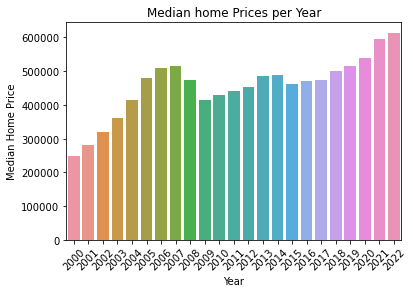

In [65]:
#Plot median price of homes
sns.barplot(x = median_home_prices.index, y =median_home_prices.values)
plt.title("Median home Prices per Year")
plt.xlabel('Year')
plt.ylabel('Median Home Price')
plt.xticks(rotation=45)
plt.show()

## Hypothesis Test

In [94]:
#Create table for homes with finished and unfinished permits
finished = sdat_with_permits.loc[sdat_with_permits.finaleddate.notnull()]
unfinished = sdat_with_permits.loc[(sdat_with_permits.finaleddate.isnull()) &
                                  (sdat_with_permits.issueddate.notnull())]

#Extract the year and cost of a home sold with finished and unfinished permits
year_1, cost_1 = unfinished_permit_price_n_year(unfinished)
year_2, cost_2 = finaled_permit_price_n_year(finished)

#convert extracted data into dataframes
df_unfinished = pd.DataFrame(list(zip(year_1, cost_1)),columns =['Year_sold', 'Cost'])
df_finished = pd.DataFrame(list(zip(year_2, cost_2)),columns =['Year_sold', 'Cost'])


In [98]:
#find average home price by year for homes with finished and unfinished permits
unfinished_values= df_unfinished.loc[df_unfinished.Cost != 0].groupby('Year_sold')['Cost'].agg('mean').values
finished_values = df_finished.loc[df_finished.Cost != 0].groupby('Year_sold')['Cost'].agg('mean').values

In [105]:
#Calculate P-value
print(sm.stats.ttest_ind(unfinished_values,finished_values))
print(sm.stats.ztest(unfinished_values,finished_values))

(1.278604866864308, 0.207739445649448, 44.0)
(1.278604866864305, 0.2010362352681575)


## Number of title transfers per year

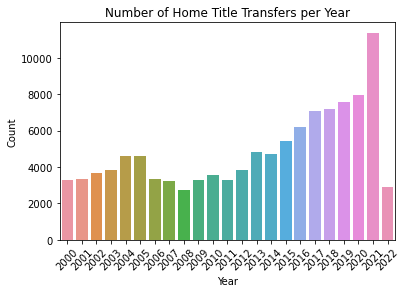

In [67]:
##Create table for houses title transfers which were more than $0
k = sdat_res.year.loc[sdat_res.sales_price >0].value_counts()

#Plot title transfers homes
sns.barplot(x = k.index, y =k.values)
plt.title("Number of Home Title Transfers per Year")
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Number of homes built per year

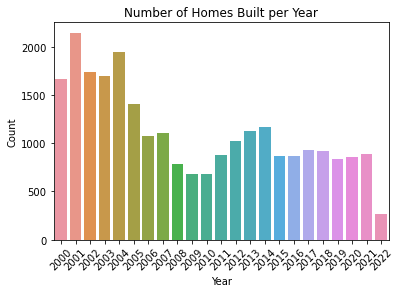

In [68]:
#Create table for number houses built excluding entries with missing year of home construction
k = complete_construction_permits.loc[complete_construction_permits['year'] != 0].year.value_counts()

#Plot number of houses bult
sns.barplot(x = k.index, y =k.values)
plt.title("Number of Homes Built per Year")
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

## Top 10 Cities 

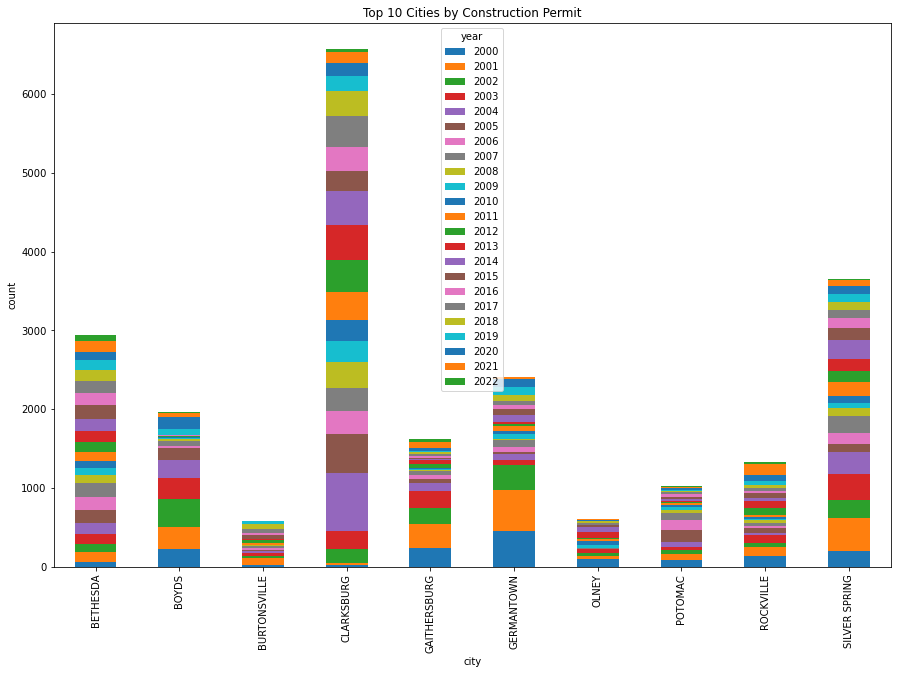

In [69]:
#extract top 10 zipcode by permit count
t = complete_construction_permits[complete_construction_permits['issueddate'].notnull()].groupby(['city'])['city'].agg('count')
t = t.sort_values(ascending=False)
top = list(t.index[:10])

date = complete_construction_permits.loc[(complete_construction_permits['city'].isin(top)) &
                                 (complete_construction_permits['year'] != 0)].groupby(['city'])['year'].value_counts()
date = date.unstack()

#Plot top 10 cities by construction permits
date.plot(kind='bar', stacked=True, figsize=(15,10), title='Top 10 Cities by Construction Permit',
                  ylabel = 'count')
plt.show()

## Number of homes built in top 10 cities by zip code

In [138]:
#table of homes built in the top 10 cities by zipcode
complete_construction_permits.replace(2081.0, 20816, inplace = True)
date2 = complete_construction_permits.loc[(complete_construction_permits['city'].isin(top)) &
                                         (complete_construction_permits['zip'] != 0)].groupby(['city'])['zip'].value_counts()
date2

city           zip  
BETHESDA       20817    1600
               20814     997
               20816     424
               20852       4
               20815       1
BOYDS          20841    1985
               20874       2
BURTONSVILLE   20866     590
CLARKSBURG     20871    6604
               20841       7
GAITHERSBURG   20882     696
               20878     544
               20879     298
               20877     107
GERMANTOWN     20874    1925
               20876     524
               20879       1
OLNEY          20832     605
POTOMAC        20854    1051
ROCKVILLE      20850     476
               20855     400
               20852     263
               20853     187
               20851      26
               20854       5
SILVER SPRING  20906    1337
               20904     871
               20902     597
               20905     431
               20910     347
               20901     133
               20903      24
Name: zip, dtype: int64

## Property Types in Top 10 Cities

In [70]:
#Frequency table to show types of homes built in top 10 cities
t = complete_construction_permits[(complete_construction_permits['finaleddate'].notnull()) &
                                (complete_construction_permits['city'].isin(top))].groupby(['city'])['usecode'].value_counts()
t = t.unstack()
t = t.apply(lambda x: x/x.sum() ,axis = 1)
t

usecode,DUPLEX,MODULAR,MULTI-FAMILY DWELLING,MULTI-FAMILY SENIOR CITIZEN BL,MULTIFAMILY DWELLING HIGH RISE,MULTIFAMILY DWELLING LOW RISE,SENIOR TOWNHOUSE,SENIOR VILLAS,SINGLE FAMILY DWELLING,TOWNHOUSE
city,,,,,,,,,,
BETHESDA,NaN,0.008917,0.021136,0.000661,0.006275,0.001982,NaN,NaN,0.923052,0.037979
BOYDS,0.004529,0.003020,0.001007,NaN,NaN,NaN,NaN,NaN,0.823352,0.168093
BURTONSVILLE,NaN,0.005085,0.040678,NaN,NaN,NaN,NaN,NaN,0.684746,0.269492
CLARKSBURG,0.001059,0.000756,0.134775,0.000151,0.000151,0.023446,0.001966,0.001815,0.440327,0.395553
GAITHERSBURG,0.001216,0.015805,0.003040,0.023708,NaN,0.001216,NaN,NaN,0.827964,0.127052
GERMANTOWN,NaN,0.001633,0.185714,0.001633,0.001633,0.018367,NaN,NaN,0.368980,0.422041
OLNEY,0.011570,NaN,0.059504,0.003306,NaN,NaN,NaN,NaN,0.685950,0.239669
POTOMAC,NaN,0.004757,0.141770,0.000951,0.000951,0.000951,NaN,NaN,0.822074,0.028544
ROCKVILLE,NaN,0.003682,0.069956,0.004418,0.002209,0.074374,NaN,NaN,0.535346,0.310015


## Home Building Rates

In [122]:
#Frequency table to show rate of homes built in top 10 cities
t = complete_construction_permits[(complete_construction_permits['finaleddate'].notnull()) &
                                (complete_construction_permits['city'].isin(top)) &
                                (complete_construction_permits['year'] > 2010)].groupby(['year'])['city'].value_counts()
t = t.unstack()
t = t.apply(lambda x: x/x.sum() ,axis = 0)
rate = pd.DataFrame(t.stack())
rate.reset_index(inplace=True)
rate = rate.rename(columns = {'index':'year', 0:"rate"})

pandas.core.series.Series

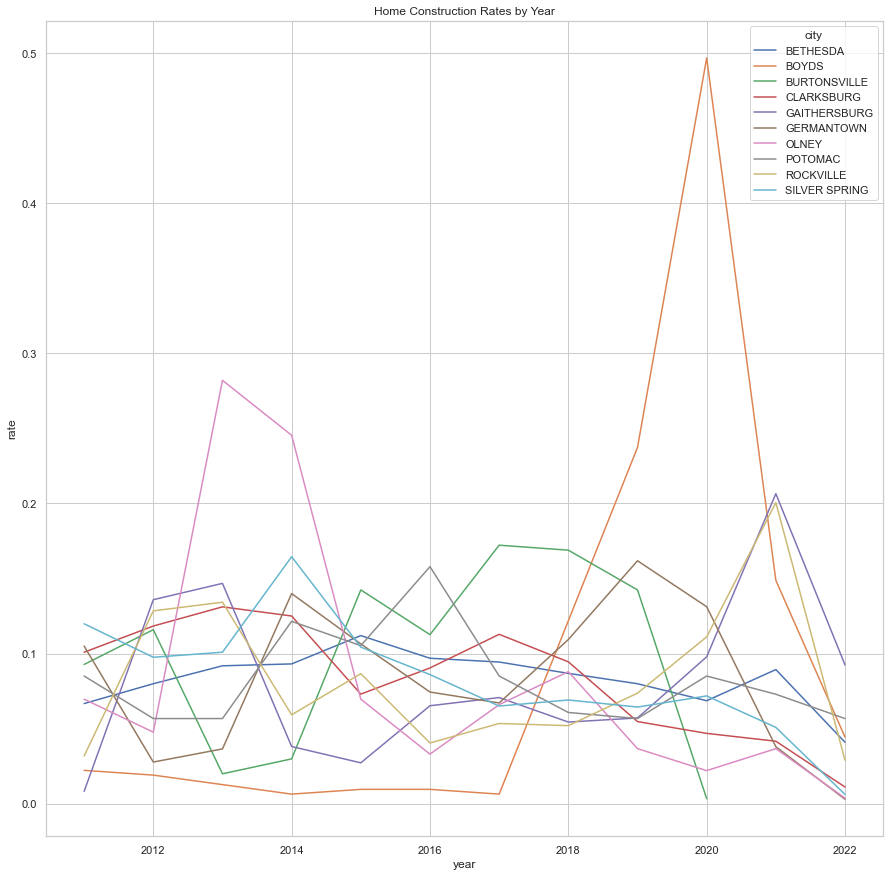

In [136]:
#Plot home construction rate by year
sns.set_style('whitegrid')
sns.lineplot(data = rate, x='year' , y= 'rate', hue = 'city' )
sns.set(rc={"figure.figsize":(15, 15)})
plt.title('Home Construction Rates by Year')

plt.show()

# Word Cloud

In [141]:
#Extract permit decription from dataframe and join them in a prompt called description
desc = []
for i,row in filtered_Res_permits_df.iterrows():
    if row.worktype != 'CONSTRUCT':
        desc.append(str(row.description))
description = '.'.join(desc)

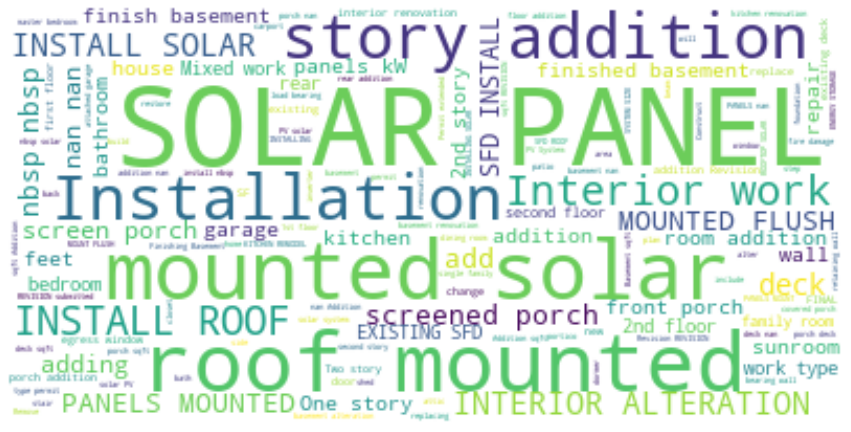

In [142]:
#list to update stopwords
update_words=['ePlans', 'Customer', 'Use', 'Want', 'Wants', "Square", "Foot", 'SQ', "FT", "ePlansCustomer"]

#update stopwords
STOPWORDS.update(update_words)

#create word cloud
cloud = WordCloud(background_color="white", stopwords=STOPWORDS).generate(description)

# Create a figure of the generated cloud
plt.imshow(cloud, interpolation='bilinear')  
plt.axis('off')
plt.show()

# Heatmap

In [72]:
#create a list of latitude and longitude for heat map
heat_data = [[row['latitude'],row['longitude']] for index, row in heatmap_coords.iterrows()]

In [110]:
zillow_with_permits.finaleddate.max()

Timestamp('2019-12-09 07:12:09')

In [109]:
#create map

#starting location to center map
m = folium.Map(location=[39.215523,-77.18297])

#create markers for map
for i,row in zillow_with_permits.iterrows():
    if row.propertyType == 'SINGLE_FAMILY':
        folium.CircleMarker((row.latitude_x,row.longitude_x), radius=5,
                            weight=2, color='blue', 
                            fill_color='white', 
                            fill_opacity=.5,
                            tooltip= row.address,
                            popup=f"""<i>
                            Zpid: {row.zpid}
                            Price: {row.price},
                            Permit work: {row.worktype},
                            Description of Work:{row.description},
                            Issue Date: {row.issueddate},
                            final date: {row.finaleddate}
                            </i>""").add_to(m)
    elif row.propertyType == 'TOWNHOUSE':
        folium.CircleMarker((row.latitude_x,row.longitude_x), radius=5,
                            weight=2, color='green', 
                            fill_color='white', 
                            fill_opacity=.5,
                            tooltip= row.address,
                            popup=f"""<i>
                            Zpid: {row.zpid}
                            Price: {row.price},
                            Permit work: {row.worktype},
                            Description of Work:{row.description},
                            Issue Date: {row.issueddate},
                            final date: {row.finaleddate}
                            </i>""").add_to(m)
    elif row.propertyType == 'CONDO':
        folium.CircleMarker((row.latitude_x,row.longitude_x), radius=5,
                            weight=2, color='black', 
                            fill_color='white', 
                            fill_opacity=.5,
                            tooltip= row.address,
                            popup=f"""<i>
                            Zpid: {row.zpid},
                            Price: {row.price},
                            Permit work: {row.worktype},
                            Description of Work:{row.description},
                            Issue Date: {row.issueddate},
                            final date: {row.finaleddate}
                            </i>""").add_to(m)

               
#plot heat map
HeatMap(heat_data, min_opacity=0.1).add_to(folium.FeatureGroup(name='Heat Map').add_to(m))
folium.LayerControl().add_to(m)

#show map
display(m)

# Reference

https://stackoverflow.com/questions/22245171/how-to-lowercase-a-pandas-dataframe-string-column-if-it-has-missing-values

https://stackoverflow.com/questions/9744775/how-to-convert-integer-timestamp-to-python-datetime

https://towardsdatascience.com/making-3-easy-maps-with-python-fb7dfb1036

https://www.kaggle.com/code/daveianhickey/how-to-folium-for-maps-heatmaps-time-data/notebook#Heatmaps,-boo-ya!

https://www.coursera.org/learn/inferential-statistical-analysis-python/